# Particle filtering for ODEs

In this tutorial we explain how to use `ProbNum` for particle filtering.
We assume that you have read the tutorial on non-linear filtering.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probnum import filtsmooth, randvars, diffeq, randprocs, problems
from probnum.problems import TimeSeriesRegressionProblem
from scipy import stats

In [2]:
rng = np.random.default_rng(seed=123)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

# Consistent plotting styles for particles and for "true" latent states
particle_style = {
    "color": "C1",
    "marker": "o",
    "markersize": 5,
    "linestyle": "None",
    "alpha": 0.5,
}
latent_state_style = {"color": "C0", "linewidth": 5, "linestyle": "-", "alpha": 0.5}

/tmp/ipykernel_18820/4149861519.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


## ODEs

Particle filters can also be used to solve ODEs (in a very basic way -- if you need a reliant method, use the ODE solvers in `diffeq` instead).

Let us consider a Bernoulli equation,
$$
\dot y(t) = 1.5 (y - y^3), \quad y(0) \approx 0,
$$

which has two stable equilibria: one at $\pm 1$ each, which are reached depending on the sign of the initial value. There is also an unstable equilibrium at $0.$.

We begin by setting up this ODE in the language of `probnum.diffeq`.

In [4]:
def bern_rhs(t, x):
    return 1.5 * (x - x ** 3)


def bern_jac(t, x):
    return np.array([1.5 * (1 - 3 * x ** 2)])


t0, tmax = 0.0, 6.0
y0 = np.array([0.0])
bernoulli = problems.InitialValueProblem(t0=t0, tmax=tmax, y0=y0, f=bern_rhs, df=bern_jac)

We will not go into detail about how to turn an ODE into a filtering problem, but in a nutshell: you need a `statespace.Integrator` prior, and a measurement model that "punishes" the discrepancy of the ODE $\dot y - f(y)$. We construct both. As an initial random variable we choose a Gaussian random variable (whose dimension must match the dimension of the prior, not of the ODE!). We add a bit of "evaluation variance" (`evlvar`), because the particle filter struggles with noise-free observations.

In [5]:
dynamod = randprocs.markov.integrator.IntegratedWienerTransition(num_derivatives=2, wiener_process_dimension=1, forward_implementation="sqrt")

initmean = np.array([0.0, 0, 0.0])
initcov = 0.0125 * np.diag([1, 1.0, 1.0])
initrv = randvars.Normal(initmean, initcov, cov_cholesky=np.sqrt(initcov))

As in the pendulum example, we use an extended Kalman filter importance distribution.

In [6]:
num_particles = 50
ode_prior = randprocs.markov.MarkovProcess(transition=dynamod, initrv=initrv, initarg=0.0)
importance = filtsmooth.particle.LinearizationImportanceDistribution.from_ekf(
    dynamod, backward_implementation="sqrt", forward_implementation="sqrt"
)

ode_pf = filtsmooth.particle.ParticleFilter(
    ode_prior,
    rng=rng,
    importance_distribution=importance,
    num_particles=num_particles,
)

The ODE filtering problem consists of evenly spaced points and data that is equal to zero. The rest is `ParticleFilter.filter()`.

In [7]:
num_locs = 50
data = np.zeros((num_locs, 1))
locs = np.linspace(0.0, tmax, num_locs)

info_op = diffeq.odefilter.information_operators.ODEResidual(num_prior_derivatives=2, ode_dimension=1)
ek1 = diffeq.odefilter.approx_strategies.EK1()

regression_problem = diffeq.odefilter.utils.ivp_to_regression_problem(
    ivp=bernoulli,
    locations=locs,
    ode_information_operator=info_op,
    approx_strategy=ek1,
    exclude_initial_condition=True,
    ode_measurement_variance=0.00001,
)

ode_posterior, _ = ode_pf.filter(regression_problem)

We plot the entire set of particles. Again, we resample in order to exclude the unlikely particles from the visualization.

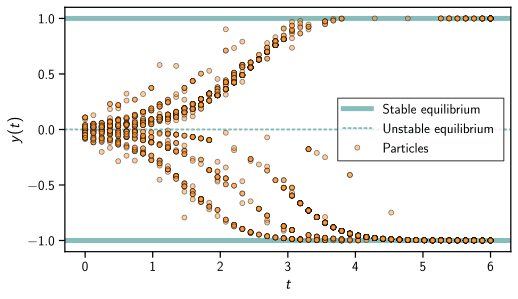

In [8]:
plt.axhline(+1, **latent_state_style, label="Stable equilibrium")
plt.axhline(0.0, linestyle="dotted", alpha=0.5, label="Unstable equilibrium")
plt.axhline(-1, **latent_state_style)
plt.xlabel(r"$t$")
plt.ylabel(r"$y(t)$")
plt.plot(
    locs,
    ode_posterior.states.resample(rng=rng).support[:, :, 0],
    **particle_style,
    label="Particles"
)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

Depending on the position of the initial particle (which is a sample from the initial random variable), the trajectories either approach +1 or -1. Eventually, they all get there.

## Summary

Particle filtering seamlessly blends into the filtering and smoothing code in ProbNum. It can be constructed with the same ingredients as a Gaussian filter, but of course there are fewer restrictions on tractability in those models (any non-linear discrete model works well).
Choices are the bootstrap filter (if `linearized_measurement_model` is left empty) or one with a Gaussian filter used as an importance density (if e.g. `DiscreteUKFComponent` or `DiscreteEKFComponent`) are provided.

Its results infer the true latent states well on simple problems, and the family of particles displays differnet paths of the potential solution (which is especially evident in the ODE example).